In [1]:
!pip install segmentation_models_pytorch

# Iniatial

In [2]:
!mkdir Master
!mkdir /content/Master/instances
!mkdir /content/Master/Output

# !wget -P Master http://images.cocodataset.org/zips/val2017.zip
!wget -P Master http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip
!wget -P /content/Master/instances http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget -P Master http://images.cocodataset.org/zips/train2017.zip

--2023-06-04 07:23:33--  http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.8.151, 52.217.195.129, 3.5.29.133, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.8.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 860725834 (821M) [application/zip]
Saving to: ‘Master/panoptic_annotations_trainval2017.zip’

panoptic_annotation 100%[===================>] 820.85M  95.5MB/s    in 8.5s    

2023-06-04 07:23:41 (96.1 MB/s) - ‘Master/panoptic_annotations_trainval2017.zip’ saved [860725834/860725834]

--2023-06-04 07:23:41--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.140.233, 52.217.105.116, 52.216.138.179, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.140.233|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25

In [ ]:
# !unzip /content/Master/val2017.zip -d Master
!unzip /content/Master/panoptic_annotations_trainval2017.zip -d Master
!unzip /content/Master/instances/annotations_trainval2017.zip -d /content/Master/instances
!unzip /content/Master/train2017.zip -d Master

Streaming output truncated to the last 5000 lines.
 extracting: Master/train2017/000000103581.jpg  
 extracting: Master/train2017/000000004608.jpg  
 extracting: Master/train2017/000000529532.jpg  
 extracting: Master/train2017/000000023311.jpg  
 extracting: Master/train2017/000000048905.jpg  
 extracting: Master/train2017/000000570263.jpg  
 extracting: Master/train2017/000000120666.jpg  
 extracting: Master/train2017/000000548471.jpg  
 extracting: Master/train2017/000000121965.jpg  
 extracting: Master/train2017/000000524535.jpg  
 extracting: Master/train2017/000000350675.jpg  
 extracting: Master/train2017/000000537456.jpg  
 extracting: Master/train2017/000000470613.jpg  
 extracting: Master/train2017/000000580837.jpg  
 extracting: Master/train2017/000000050410.jpg  
 extracting: Master/train2017/000000255158.jpg  
 extracting: Master/train2017/000000500356.jpg  
 extracting: Master/train2017/000000241911.jpg  
 extracting: Master/train2017/000000181990.jpg  
 extracting: Maste

In [ ]:
# !unzip /content/Master/annotations/panoptic_val2017.zip -d Master
# !mv /content/Master/annotations/panoptic_val2017.json /content/Master # move src dest
# !mv /content/Master/instances/annotations/instances_val2017.json /content/Master # move src dest
# # !unzip /content/Master/panoptic_annotations_trainval2017.zip -d Master

!rm -r /content/Master/panoptic_annotations_trainval2017.zip
!rm -r /content/Master/train2017.zip

!unzip /content/Master/annotations/panoptic_train2017.zip -d Master
!mv /content/Master/annotations/panoptic_train2017.json /content/Master # move src dest
!mv /content/Master/instances/annotations/instances_train2017.json /content/Master # move src dest
# !unzip /content/Master/panoptic_annotations_trainval2017.zip -d Master

In [ ]:
!rm -r /content/Master/val2017.zip
# !rm -r /content/Master/panoptic_annotations_trainval2017.zip
# !rm -r /content/Master/train2017.zip

import shutil

shutil.rmtree('/content/Master/annotations', ignore_errors=True)
shutil.rmtree('/content/Master/instances', ignore_errors=True)
shutil.rmtree('/content/Master/__MACOSX', ignore_errors=True)

In [ ]:
# import shutil

# shutil.rmtree('/content/Proiect-Dizertatie', ignore_errors=True)
# shutil.rmtree('/content/Master/instances', ignore_errors=True)

# Libraries

In [ ]:
# For managing COCO dataset
from pycocotools.coco import COCO

# For creating and managing folder/ files
import glob
import os
import shutil

# For managing images
from PIL import Image
import skimage.io as io

# Basic libraries
import numpy as np
import pandas as pd
import random
import cv2

# For plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# For importing models and working with them
## Torch
import torch
import torch.utils.data # for Dataset
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

## Torchvision
import torchvision
from torchvision.transforms import transforms

# For creating train - test splits
from sklearn.model_selection import train_test_split

import pathlib
import pylab
import requests
from io import BytesIO
from pprint import pprint
from tqdm import tqdm
import time
from imutils import paths

# Performance Metrics
from sklearn.metrics import multilabel_confusion_matrix


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# %matplotlib inline

# Configuration

In [ ]:
data = 'train2017'

# Data and Masks
IMAGE_PATH = os.path.join('/content/Master/', data)
MASK_PATH = os.path.join('/content/Master/', 'panoptic_' + data)

# define the path to the base output directory
BASE_OUTPUT = '/content/Master/Output'

# define the path to the output serialized model, model training plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])



# determine if we will be pinning memory during data loading
PIN_MEMORY = True if device == "cuda" else False


# define the number of channels in the input, number of classes, and number of levels in the U-Net model
# NUM_CHANNELS = 3
# NUM_CLASSES = 2 # person vs Background

# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256

# define threshold to filter weak predictions
THRESHOLD = 0.5 # for binary classification

# Functions

In [ ]:
def gen_binary_mask (img, coco, anns):
  mask = np.zeros((img['height'], img['width']))

  for i in range(len(anns)):
      
      mask = np.maximum(mask, coco.annToMask(anns[i]) * anns[i]['category_id'] )

  return mask


In [ ]:
def calculate_metrics(gt_masks, pred_masks):
    tp = 0  # true positive
    tn = 0  # true negative
    fp = 0  # false positive
    fn = 0  # false negative

    for gt_mask, pred_mask in zip(gt_masks, pred_masks):
        gt_mask = gt_mask.flatten()
        pred_mask = pred_mask.flatten()

        tp += np.sum(np.logical_and(pred_mask == 1, gt_mask == 1))
        tn += np.sum(np.logical_and(pred_mask == 0, gt_mask == 0))
        fp += np.sum(np.logical_and(pred_mask == 1, gt_mask == 0))
        fn += np.sum(np.logical_and(pred_mask == 0, gt_mask == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

In [ ]:
def calculate_dice_coefficient(gt_masks, pred_masks):
    intersection = np.logical_and(gt_masks, pred_masks)
    dice_coefficient = (2.0 * intersection.sum()) / (gt_masks.sum() + pred_masks.sum())
    return dice_coefficient

def calculate_iou(gt_masks, pred_masks):
    intersection = np.logical_and(gt_masks, pred_masks)
    union = np.logical_or(gt_masks, pred_masks)
    iou = intersection.sum() / union.sum()
    return iou

In [ ]:
def train_model(model, dataloader, steps, loss_function, optim, device):
  print("Training...")

  model.train()
  
  totalTrainLoss = 0

  # loop over the training set
  for i, (x, y) in enumerate(dataloader):
      
      # send the input to the device
      (x, y) = (x.to(device), y.to(device))
      
      # perform a forward pass and calculate the training loss
      pred = model(x)
      loss = loss_function(pred, y)
      
      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      optim.zero_grad()
      loss.backward()
      optim.step()
      
      # add the loss to the total training loss so far
      totalTrainLoss += loss


  avgTrainLoss = totalTrainLoss / steps

  return avgTrainLoss

In [ ]:
def validate_model(model, dataloader, steps, loss_function, optim, device):
  print("Validating...")

  model.eval()

  totalTrainLoss = 0

  # loop over the training set
  with torch.no_grad():
    for i, (x, y) in enumerate(dataloader):
        
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = loss_function(pred, y)
                
        # add the loss to the total training loss so far
        totalTrainLoss += loss


    avgTrainLoss = totalTrainLoss / steps

    return avgTrainLoss

## Dataset

In [ ]:
class SegmentationDataset(Dataset):
    
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        
        
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    
    
    def __getitem__(self, idx):

        image = Image.open(self.imagePaths[idx]).convert("RGB")
        mask = Image.open(self.maskPaths[idx]).convert("L")
        
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)

            
        # return a tuple of the image and its mask
        return (image, mask)

# Data

## Data Preparation

In [ ]:
# Prepare Directory for Binary Masks
shutil.rmtree('/content/Master/Binary_Masks', ignore_errors = True)

!mkdir /content/Master/Binary_Masks



# Load COCO annotations 
ann = '/content/Master/instances_train2017.json'

# Initialize the COCO api for instance annotations
coco = COCO(ann)

# Define the classes (out of the 81) which you want to see. Others will not be shown - just Person
filterClasses = ['person']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms = filterClasses) 

# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds = catIds)
print("Number of images containing all the classes:", len(imgIds))


# Lists of Person Images and Masks
imagePaths = []
maskPaths = []
binaryMaskPaths = []

for i in range (0, len(imgIds)):

    if i % 1000 ==0:
      print(i)

    img = coco.loadImgs(imgIds[i])[0]

    # I = io.imread('/content/Master/val2017/' + img['file_name'])/255.0
    # plt.imshow(I)
    # plt.axis('off')

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    # coco.showAnns(anns)

    bin_mask = gen_binary_mask (img, coco, anns)
    bin_mask = (bin_mask * 255).astype(np.uint8)
    bin_mask = Image.fromarray(bin_mask) # Convert the array to a PIL Image

    if bin_mask.mode != 'L':
      bin_mask = bin_mask.convert('L')

    # plt.imshow(bin_mask)
    bin_mask.save('/content/Master/Binary_Masks/' + img['file_name'][:12] + '.png') # Save the mask image to disk

    # break

    imagePaths.append((IMAGE_PATH + '/' + img['file_name']))
    maskPaths.append((MASK_PATH + '/' + img['file_name'][:12] + '.png'))
    binaryMaskPaths.append('/content/Master/Binary_Masks/' + img['file_name'][:12] + '.png')

In [ ]:
# IMG_PATHS = os.path.sep.join([BASE_OUTPUT, "img_paths.txt"])
# BMASKS_PATHS = os.path.sep.join([BASE_OUTPUT, "bmasks_paths.txt"])

# print("[INFO] saving image paths...")
# f = open(IMG_PATHS, "w")
# f.write("\n".join(imagePaths))
# f.close()

# print("[INFO] saving binary masks paths...")
# f = open(BMASKS_PATHS, "w")
# f.write("\n".join(binaryMaskPaths))
# f.close()

[INFO] saving image paths...
[INFO] saving binary masks paths...


In [ ]:
data = {'Image_Paths': imagePaths, 
        'Binary_Paths': binaryMaskPaths,
        # 'Mask_Paths': maskPaths
       }

df = pd.DataFrame(data = data)
shuffled_df_new = df.sample(frac = 1, random_state = 49)

shuffled_df_copy = shuffled_df_new.copy()

shuffled_df_small = shuffled_df_copy.head(9000)
shuffled_df_medium = shuffled_df_copy.head(15000)
shuffled_df_large = shuffled_df_copy.head(30000)

shuffled_df_small.to_csv('shuffled_df_small.csv', index=False)
shuffled_df_medium.to_csv('shuffled_df_medium.csv', index=False)
shuffled_df_large.to_csv('shuffled_df_large.csv', index=False)
shuffled_df_copy.to_csv('shuffled_df_all.csv', index=False)

## Train Test Split

In [ ]:
# # Lists of images and masks 
# # imagePaths = arr_images
# # maskPaths = arr_masks

# # Split data into train and test
# TEST_SPLIT = 0.3
# VALID_SPLIT = 0.15

# ##### TRAIN - TEST SPLIT ######
# # split = train_test_split(imagePaths, maskPaths, test_size = TEST_SPLIT, random_state = 19)
# split = train_test_split(imagePaths, binaryMaskPaths, test_size = TEST_SPLIT, random_state = 19)

# # Unpack the data split
# (trainImages, testImages) = split[:2]
# (trainMasks, testMasks) = split[2:]


# ##### TRAIN - VALIDATION SPLIT ######
# split = train_test_split(trainImages, trainMasks, test_size = VALID_SPLIT, random_state = 19)

# # Unpack the data split
# (trainImages, valImages) = split[:2]
# (trainMasks, valMasks) = split[2:]

# # print(len(trainImages))
# # print(len(testImages))
# # print(len(valImages))

# # Write the testing image paths to disk so that we can use then when evaluating/testing our model
# print("[INFO] saving testing image paths...")

# f = open(TEST_PATHS, "w")
# f.write("\n".join(testImages))
# f.close()

In [ ]:
# # For the Original Image
# p = trainImages[1547]
# image = cv2.imread(p)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# print(image.shape)
# plt.imshow(image)


# # # For the Binary Mask
# # p = trainMasks[1547]
# # image = cv2.imread(p)
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# # print(image.shape)
# # plt.imshow(p)

In [ ]:
# # For the Binary Mask
# p = trainMasks[1547]
# # image = cv2.imread(p)
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# # print(image.shape)
# # plt.imshow(p)

# binary_mask = Image.open(p)
# binary_mask_array = np.array(binary_mask)
# binary_mask_array = binary_mask_array.astype(np.uint8)

# # Plot the binary mask image
# plt.imshow(binary_mask_array, cmap='gray')
# plt.axis('off')
# plt.show()

## Datasets and Dataloaders

In [ ]:
# INIT_LR = 0.0001
# BATCH_SIZE = 32 
INPUT_IMAGE_HEIGHT = 224

# define transformations
transforms_train = torchvision.transforms.Compose([#transforms.ToPILImage(),
                                                   transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
                                                   transforms.ToTensor(),
                                                  #  transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                  #                       std = [0.229, 0.224, 0.225])
                                                  ])

transforms_test = torchvision.transforms.Compose([#transforms.ToPILImage(),
                                                  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
                                                  transforms.ToTensor()
                                                 ])

# # create the train and test datasets
# trainDS = SegmentationDataset(imagePaths = trainImages, maskPaths = trainMasks, transforms = transforms_train)
# valDS = SegmentationDataset(imagePaths = valImages, maskPaths = valMasks, transforms = transforms_test)
# testDS = SegmentationDataset(imagePaths = testImages, maskPaths = testMasks, transforms = transforms_test)


# print(f"[INFO] found {len(trainDS)} examples in the training set...")
# print(f"[INFO] found {len(valDS)} examples in the validation set...")
# print(f"[INFO] found {len(testDS)} examples in the test set...")


# # create the training and test data loaders
# trainLoader = DataLoader(trainDS, 
#                          shuffle = True,
#                          batch_size = BATCH_SIZE, 
#                          pin_memory = PIN_MEMORY
# #                          num_workers = os.cpu_count()
#                         )

# valLoader = DataLoader(valDS, 
#                        shuffle = True,
#                        batch_size = BATCH_SIZE, 
#                        pin_memory = PIN_MEMORY

#                       )
# testLoader = DataLoader(testDS, 
#                         shuffle = False,
#                         batch_size = BATCH_SIZE, 
#                         pin_memory = PIN_MEMORY
# #                         num_workers = os.cpu_count()
#                        )

## Configure Model

In [ ]:
# https://github.com/qubvel/segmentation_models.pytorch
# https://github.com/qubvel/segmentation_models.pytorch#architectures
    
import segmentation_models_pytorch as smp

unet = smp.Unet(
                    encoder_name = "resnet101", #"resnet34",                    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    encoder_weights = "imagenet", #"imagenet",                 # use `imagenet` pre-trained weights for encoder initialization
                    # in_channels = NUM_CHANNELS,                   # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                    # classes = NUM_CHANNELS,                        # model output channels (number of classes in your dataset) - person vs bg
                ).to(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:03<00:00, 50.3MB/s]


## Train

[INFO] TEST_SPLIT = 0.3 ...
Splits, Datasets and Dataloaders
[INFO] saving testing image paths...
[INFO] Total time taken to create the datasets and dataloaders: 0.03s
[INFO] found 5670 examples in the training set...
[INFO] found 630 examples in the validation set...
[INFO] found 2700 examples in the test set...
[INFO] Training the network for 10 epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training...
Validating...


 10%|█         | 1/10 [04:06<36:55, 246.18s/it]

[INFO] EPOCH: 1/10
Train loss: 0.241041, Validation loss: 0.1744, Test loss: 0.1678
Training...
Validating...


 20%|██        | 2/10 [07:59<31:46, 238.37s/it]

[INFO] EPOCH: 2/10
Train loss: 0.141598, Validation loss: 0.1478, Test loss: 0.1415
Training...
Validating...


 30%|███       | 3/10 [11:52<27:33, 236.18s/it]

[INFO] EPOCH: 3/10
Train loss: 0.108496, Validation loss: 0.1370, Test loss: 0.1383
Training...
Validating...


 40%|████      | 4/10 [15:43<23:24, 234.09s/it]

[INFO] EPOCH: 4/10
Train loss: 0.094454, Validation loss: 0.1553, Test loss: 0.1528
Training...
Validating...


 50%|█████     | 5/10 [19:34<19:24, 232.86s/it]

[INFO] EPOCH: 5/10
Train loss: 0.090650, Validation loss: 0.1439, Test loss: 0.1354
Training...
Validating...


 60%|██████    | 6/10 [23:24<15:28, 232.15s/it]

[INFO] EPOCH: 6/10
Train loss: 0.075183, Validation loss: 0.1329, Test loss: 0.1316
Training...
Validating...


 70%|███████   | 7/10 [27:16<11:35, 231.83s/it]

[INFO] EPOCH: 7/10
Train loss: 0.079889, Validation loss: 0.1357, Test loss: 0.1344
Training...
Validating...


 80%|████████  | 8/10 [31:05<07:42, 231.17s/it]

[INFO] EPOCH: 8/10
Train loss: 0.066465, Validation loss: 0.1360, Test loss: 0.1320
Training...
Validating...


 90%|█████████ | 9/10 [34:50<03:49, 229.21s/it]

[INFO] EPOCH: 9/10
Train loss: 0.058582, Validation loss: 0.1290, Test loss: 0.1307
Training...
Validating...


100%|██████████| 10/10 [38:35<00:00, 231.57s/it]

[INFO] EPOCH: 10/10
Train loss: 0.051809, Validation loss: 0.1319, Test loss: 0.1330
[INFO] Total time taken to train the model: 2315.71s




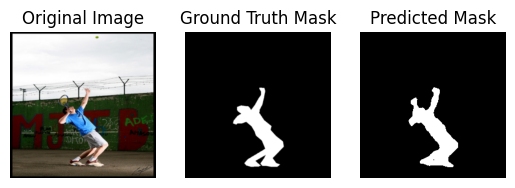

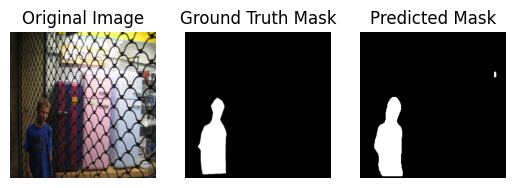

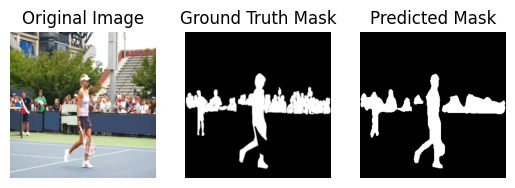

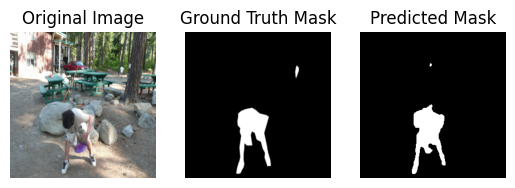

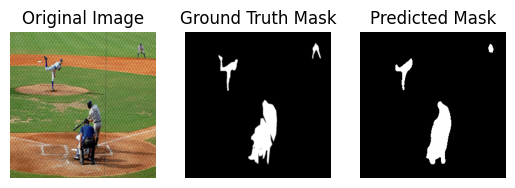

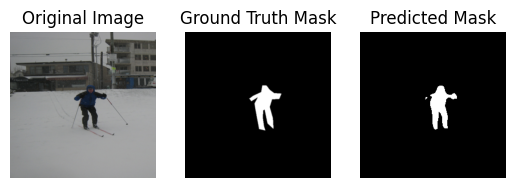

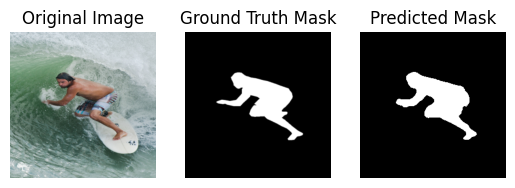

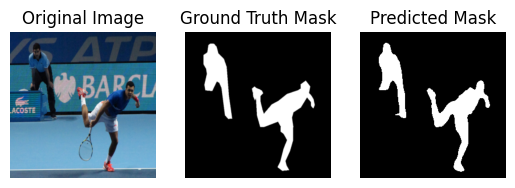

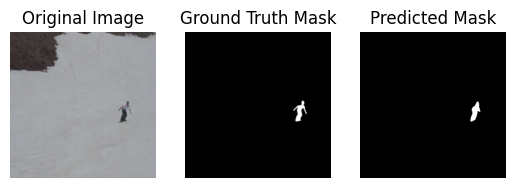

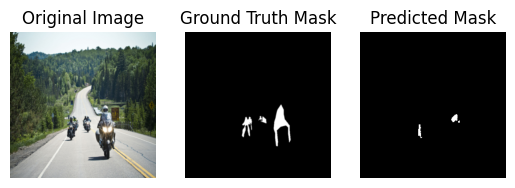

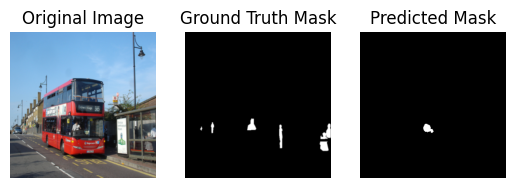

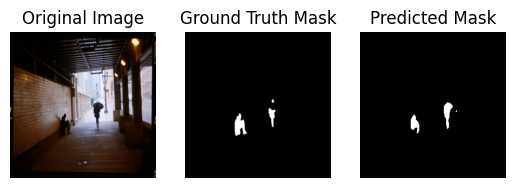

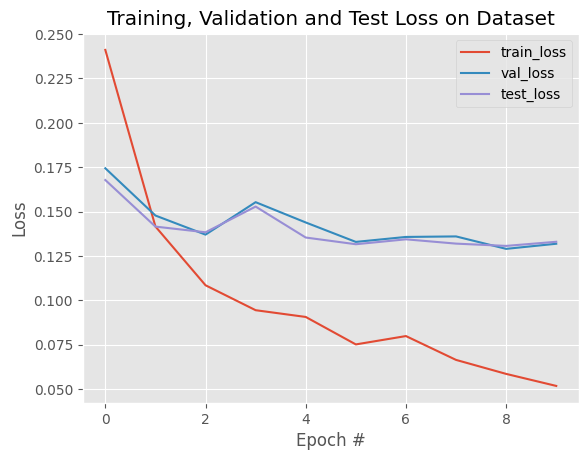

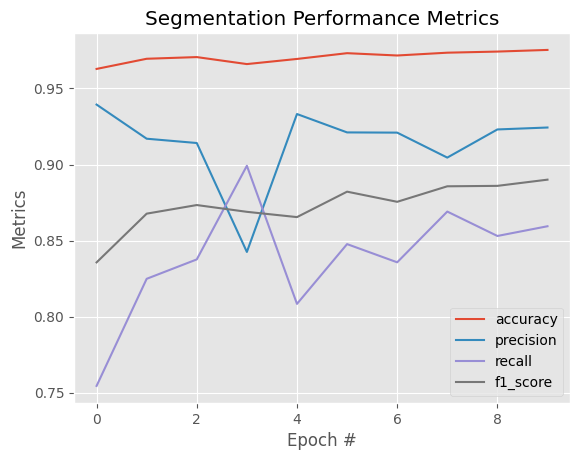

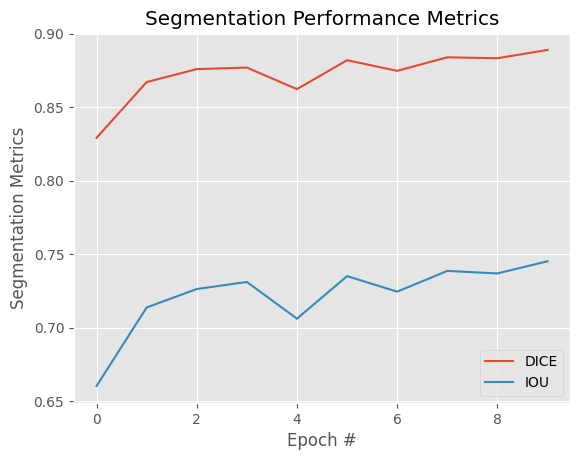



[INFO] Training the network for 20 epochs...


  0%|          | 0/20 [00:00<?, ?it/s]

Training...
Validating...


  5%|▌         | 1/20 [03:40<1:09:40, 220.04s/it]

[INFO] EPOCH: 1/20
Train loss: 0.046783, Validation loss: 0.1385, Test loss: 0.1367
Training...
Validating...


 10%|█         | 2/20 [07:19<1:05:55, 219.74s/it]

[INFO] EPOCH: 2/20
Train loss: 0.043679, Validation loss: 0.1409, Test loss: 0.1375
Training...
Validating...


 15%|█▌        | 3/20 [10:59<1:02:18, 219.91s/it]

[INFO] EPOCH: 3/20
Train loss: 0.041200, Validation loss: 0.1534, Test loss: 0.1489
Training...
Validating...


 20%|██        | 4/20 [14:40<58:41, 220.10s/it]  

[INFO] EPOCH: 4/20
Train loss: 0.077264, Validation loss: 0.1452, Test loss: 0.1392
Training...
Validating...


 25%|██▌       | 5/20 [18:20<55:05, 220.34s/it]

[INFO] EPOCH: 5/20
Train loss: 0.055366, Validation loss: 0.1491, Test loss: 0.1456
Training...
Validating...


 30%|███       | 6/20 [22:00<51:20, 220.03s/it]

[INFO] EPOCH: 6/20
Train loss: 0.046464, Validation loss: 0.1475, Test loss: 0.1468
Training...
Validating...


 35%|███▌      | 7/20 [25:39<47:37, 219.79s/it]

[INFO] EPOCH: 7/20
Train loss: 0.042122, Validation loss: 0.1526, Test loss: 0.1520
Training...
Validating...


 40%|████      | 8/20 [29:20<44:01, 220.14s/it]

[INFO] EPOCH: 8/20
Train loss: 0.045819, Validation loss: 0.1558, Test loss: 0.1522
Training...
Validating...


 45%|████▌     | 9/20 [32:59<40:19, 219.94s/it]

[INFO] EPOCH: 9/20
Train loss: 0.037991, Validation loss: 0.1632, Test loss: 0.1598
Training...
Validating...


 50%|█████     | 10/20 [36:39<36:36, 219.70s/it]

[INFO] EPOCH: 10/20
Train loss: 0.051949, Validation loss: 0.1710, Test loss: 0.1672
Training...
Validating...


 55%|█████▌    | 11/20 [40:17<32:55, 219.44s/it]

[INFO] EPOCH: 11/20
Train loss: 0.042152, Validation loss: 0.1542, Test loss: 0.1545
Training...
Validating...


 60%|██████    | 12/20 [43:57<29:15, 219.41s/it]

[INFO] EPOCH: 12/20
Train loss: 0.035480, Validation loss: 0.1575, Test loss: 0.1598
Training...
Validating...


 65%|██████▌   | 13/20 [47:36<25:36, 219.43s/it]

[INFO] EPOCH: 13/20
Train loss: 0.031969, Validation loss: 0.1635, Test loss: 0.1610
Training...
Validating...


In [ ]:
INIT_LR = 0.0001
BATCH_SIZE = 32

NUM_EPOCHS = [10, 20, 50, 100, 150]
# TEST_SPLIT = [0.3, 0.2, 0.1]
TEST_SPLIT = [0.3]
VALID_SPLIT = 0.1


# initialize loss function and optimizer
lossFunc = nn.BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr = INIT_LR)

loaded_df = pd.read_csv(r'shuffled_df_medium.csv')
imagePaths = list(loaded_df["Image_Paths"])
binaryMaskPaths = list(loaded_df["Binary_Paths"])


for tts in TEST_SPLIT:

  print("[INFO] TEST_SPLIT = {} ...".format(tts))

  print("Splits, Datasets and Dataloaders")
  startTime = time.time()

  ##### TRAIN - TEST SPLIT ######
  split = train_test_split(imagePaths, binaryMaskPaths, test_size = tts, random_state = 19)
  (trainImages, testImages) = split[:2]
  (trainMasks, testMasks) = split[2:]


  ##### TRAIN - VALIDATION SPLIT ######
  split = train_test_split(trainImages, trainMasks, test_size = VALID_SPLIT, random_state = 19)
  (trainImages, valImages) = split[:2]
  (trainMasks, valMasks) = split[2:]

  print("[INFO] saving testing image paths...")
  f = open(TEST_PATHS, "w")
  f.write("\n".join(testImages))
  f.close()


  # create the train and test datasets
  trainDS = SegmentationDataset(imagePaths = trainImages, maskPaths = trainMasks, transforms = transforms_train)
  valDS = SegmentationDataset(imagePaths = valImages, maskPaths = valMasks, transforms = transforms_test)
  testDS = SegmentationDataset(imagePaths = testImages, maskPaths = testMasks, transforms = transforms_test)

  # create the training and test data loaders
  trainLoader = DataLoader(trainDS, shuffle = True, batch_size = BATCH_SIZE, pin_memory = PIN_MEMORY)
  valLoader = DataLoader(valDS, shuffle = True, batch_size = BATCH_SIZE, pin_memory = PIN_MEMORY)
  testLoader = DataLoader(testDS, shuffle = False, batch_size = BATCH_SIZE, pin_memory = PIN_MEMORY)

  endTime = time.time()
  print("[INFO] Total time taken to create the datasets and dataloaders: {:.2f}s".format(endTime - startTime))

  print(f"[INFO] found {len(trainDS)} examples in the training set...")
  print(f"[INFO] found {len(valDS)} examples in the validation set...")
  print(f"[INFO] found {len(testDS)} examples in the test set...")

  # calculate steps per epoch for training and test set
  trainSteps = len(trainDS) // BATCH_SIZE
  valSteps = len(valDS) // BATCH_SIZE
  testSteps = len(testDS) // BATCH_SIZE



  for epoch in NUM_EPOCHS:

    # unet = smp.Unet(
    #                 encoder_name = "resnet34",                    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #                 encoder_weights = "imagenet",                 # use `imagenet` pre-trained weights for encoder initialization
    #                 # in_channels = NUM_CHANNELS,                   # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    #                 # classes = NUM_CHANNELS,                        # model output channels (number of classes in your dataset) - person vs bg
    #                ).to(device)


    # initialize a dictionary to store training history
    H = {"train_loss": [], "val_loss": [], "test_loss": []}
    Perf_Metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}
    Dice_IOU = {"dice": [], "iou": []}

    print("[INFO] Training the network for {} epochs...".format(epoch))

    startTime = time.time()

    for e in tqdm(range(epoch)):

        avgTrainLoss = train_model(unet, trainLoader, trainSteps, lossFunc, opt, device)
        avgValLoss = validate_model(unet, valLoader, valSteps, lossFunc, opt, device)
        

        # initialize variables for output
        totalTestLoss = 0
        accuracy_scores, precision_score, recall_scores, f1_scores = 0, 0, 0, 0
        dice_scores, iou_scores = 0, 0
            
        # switch off autograd
        with torch.no_grad():
            
            # set the model in evaluation mode
            unet.eval()
            
            # loop over the validation set
            for (x, y) in testLoader:
                # send the input to the device
                (x, y) = (x.to(device), y.to(device))
                
                # make the predictions and calculate the validation loss
                pred = unet(x)
                totalTestLoss += lossFunc(pred, y)

                pred_mask = (pred > 0.5).float()

                # original_images.append(x.cpu().numpy())
                # gt_masks.append(y.cpu().numpy())
                # pred_masks.append(pred_mask.cpu().numpy())


                # calculate Dice coefficient and IoU score
                metrics = calculate_metrics(y.cpu().numpy(), pred_mask.cpu().numpy())
                accuracy, precision, recall, f1_score = metrics

                dice_coefficient = calculate_dice_coefficient(y.cpu().numpy(), pred_mask.cpu().numpy())
                iou = calculate_iou(y.cpu().numpy(), pred_mask.cpu().numpy())

                # avg metrics
                accuracy_scores += accuracy
                precision_score += precision
                recall_scores += recall
                f1_scores += f1_score

                dice_scores += dice_coefficient
                iou_scores += iou
                
        # calculate the average test loss
        avgTestLoss = totalTestLoss / testSteps

        accuracy_scores = accuracy_scores / testSteps
        precision_score = precision_score / testSteps
        recall_scores = recall_scores / testSteps
        f1_scores = f1_scores / testSteps

        dice_scores = dice_scores / testSteps
        iou_scores = iou_scores / testSteps
        
        # update our training history
        H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
        H["val_loss"].append(avgValLoss.cpu().detach().numpy())
        H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

        # update our performance metrics history
        Perf_Metrics["accuracy"].append(accuracy_scores)
        Perf_Metrics["precision"].append(precision_score)
        Perf_Metrics["recall"].append(recall_scores)
        Perf_Metrics["f1_score"].append(f1_scores)


        # update our dice and IOU score history
        Dice_IOU["dice"].append(dice_scores)
        Dice_IOU["iou"].append(iou_scores)
        
        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, epoch))
        print("Train loss: {:.6f}, Validation loss: {:.4f}, Test loss: {:.4f}".format(avgTrainLoss, avgValLoss, avgTestLoss))
        
        
    # display the total time needed to perform the training
    endTime = time.time()
    print("[INFO] Total time taken to train the model: {:.2f}s".format(endTime - startTime))

    print('\n')

    print("Average accuracy = {}%".format(100 * round(sum(Perf_Metrics["accuracy"])/len(Perf_Metrics["accuracy"]), 2)))
    print("Average precision = {}%".format(100 * round(sum(Perf_Metrics["precision"])/len(Perf_Metrics["precision"]), 2)))
    print("Average recall = {}%".format(100 * round(sum(Perf_Metrics["recall"])/len(Perf_Metrics["recall"]), 2)))
    print("Average f1_score = {}%".format(100 * round(sum(Perf_Metrics["accuracy"])/len(Perf_Metrics["f1_score"]), 2)))

    print("Average DICE = {}%".format(100 * round(sum(Dice_IOU["dice"])/len(Dice_IOU["dice"]), 2)))
    print("Average IOU = {}%".format(100 * round(sum(Dice_IOU["iou"])/len(Dice_IOU["iou"]), 2)))

    print('\n')


    lent = x.cpu().numpy().shape[0]

    for i in range (0, lent):
      # plot original image
      plt.subplot(131)
      plt.imshow(x.cpu().numpy()[i].transpose(1, 2, 0))
      plt.title('Original Image')
      plt.axis('off')

      # plot ground truth mask
      plt.subplot(132)
      plt.imshow(y.cpu().numpy()[i][0], cmap='gray')
      plt.title('Ground Truth Mask')
      plt.axis('off')

      # plot predicted mask
      plt.subplot(133)
      plt.imshow(pred_mask.cpu().numpy()[i][0], cmap='gray')
      plt.title('Predicted Mask')
      plt.axis('off')

      # display the plot
      plt.show()


    # plot the training loss
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H["train_loss"], label = "train_loss")
    plt.plot(H["val_loss"], label="val_loss")
    plt.plot(H["test_loss"], label="test_loss")
    plt.title("Training, Validation and Test Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


    # plot the performance metrics
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(Perf_Metrics["accuracy"], label = "accuracy") 
    plt.plot(Perf_Metrics["precision"], label="precision")
    plt.plot(Perf_Metrics["recall"], label="recall")
    plt.plot(Perf_Metrics["f1_score"], label="f1_score")

    plt.title("Segmentation Performance Metrics")
    plt.xlabel("Epoch #")
    plt.ylabel("Metrics")
    plt.legend()
    plt.show()


    # plot the performance metrics
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(Dice_IOU["dice"], label = "DICE") 
    plt.plot(Dice_IOU["iou"], label="IOU")

    plt.title("Segmentation Performance Metrics")
    plt.xlabel("Epoch #")
    plt.ylabel("Segmentation Metrics")
    plt.legend()
    plt.show()

    print('\n')